# Sets Analysis

In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import json
import seaborn as sns
import numpy as np

## Subset of citations

In [3]:
all_citations = pd.read_csv('../inputdata/all_cases_citations.csv')
print('Total citations relations EUR-LEX: ',len(all_citations))

Total citations relations EUR-LEX:  43780


In [4]:
sampled_cases = pd.read_csv('../inputdata/sampled_cases.csv').rename(columns={'source':'case'})
print('Total sampled cases for the study: ',len(sampled_cases))

Total sampled cases for the study:  177


In [5]:
sampled_cases.head()

,quantile,case,citations,topic
0,1.00,61990CJ0006,43,social policy
1,1.00,62003CJ0453,32,public health
2,0.99,62007CJ0378,32,social policy
3,0.98,61995CJ0261,19,social policy
4,1.00,62000CJ0465,17,data protection


Taking the subset of the whole citations files where the target is in the sample

In [5]:
citations_subset = pd.merge(all_citations, 
                    sampled_cases[['case']].rename(columns={'case':'target'}),
                    how='inner', left_on='target', right_on='target')

In [6]:
len(citations_subset)

609

---
## Citations Graph

In [7]:
citations_subset.head()

,source,target
0,61976CJ0089,61973CJ0039
1,61980CJ0132,61973CJ0039
2,61982CJ0314,61973CJ0039
3,61983CJ0001,61973CJ0039
4,61980CJ0132,61975CJ0004


In [8]:
g = nx.from_pandas_edgelist(citations_subset, 'source', 'target')
nodes = sampled_cases[['case','topic']].set_index('case').to_dict('index')
nx.set_node_attributes(g, nodes)

In [9]:
#only the sampled nodes have attributes
g.nodes()['61973CJ0039']

{'topic': 'public health'}

In [10]:
#Graph description
N_nodes, N_edges = g.order(), g.size()
avg_deg = float(N_nodes)/N_edges
print ('Nodes: {}\nEdges: {}\nAvg Degree: {}'.format(N_nodes, N_edges, avg_deg) )

Nodes: 599
Edges: 609
Avg Degree: 0.9835796387520526


In [11]:
sub1 = {node if att['topic'] =='social policy' else None for node, att in nodes.items()}
sub2 = {node if att['topic'] =='public health' else None for node, att in nodes.items()}
sub3 = {node if att['topic'] =='data protection' else None for node, att in nodes.items()}

In [12]:
subgraphs = [sub1,sub2,sub3]
colors = ["red", "skyblue", "gold"]
def find_color(node):
    for subgraph in subgraphs:
        if node in subgraph:
            return colors[subgraphs.index(subgraph)]
    return "gray"#"ghostwhite"

In [13]:
node_colors = [find_color(node) for node in g.nodes()]

draw_kamada_kawai  
draw_spring  
draw_circular  

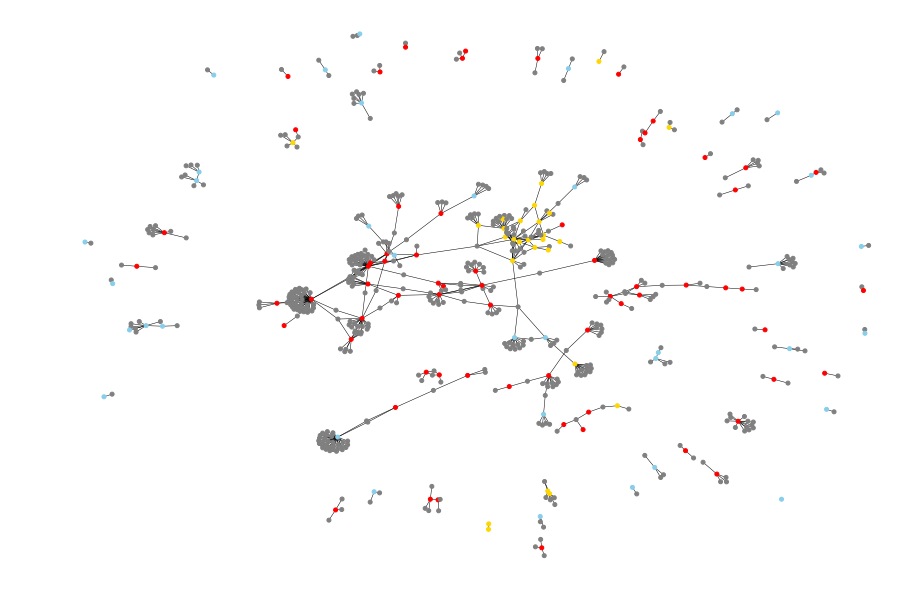

In [40]:
plt.figure(figsize=(12, 8))
nx.draw(g, with_labels=False, node_size=16, width=0.5, node_color=node_colors)
plt.show()

---
## Similarity Graph

In [15]:
casses_similarity = pd.read_csv('../outputdata/results.csv')

In [16]:
casses_similarity.head()

,source_case,similar_case,similarity_score,method,citation_link,source_case_topic
0,62003CJ0453,62006CO0421,0.727373,tfidf,True,public health
1,62003CJ0453,61984CJ0028,0.664869,tfidf,False,public health
2,62003CJ0453,61984CJ0195,0.618935,tfidf,False,public health
3,62003CJ0453,61990CJ0039,0.579735,tfidf,False,public health
4,62003CJ0453,62002CJ0145,0.566752,tfidf,False,public health


In [17]:
#are the same
#len(casses_similarity['source_case'].unique())
#len(sampled_cases)

---
#### top 4 similar filter

In [18]:
cases_sim_sorted = casses_similarity.sort_values(
    ['source_case','method','similarity_score'],ascending=False).reset_index()

In [19]:
tops4 = []
m=12034; n=10
for n in list(range(n, (m+1)*n, n)):
    tops4.append([i+n for i in [0,1,2,3]])
tops4 = [item for s in tops4 for item in s]
tops4.extend([0,1,2,3])

In [20]:
len(tops4)

48140

In [21]:
cases_similarity_top4 = cases_sim_sorted[cases_sim_sorted.index.isin(tops4)]

---

In [22]:
g2 = nx.from_pandas_edgelist(cases_similarity_top4, 'source_case', 'similar_case', edge_attr='similarity_score')
nx.set_node_attributes(g2, nodes)

In [23]:
#Graph description
N_nodes2, N_edges2 = g2.order(), g2.size()
avg_deg2 = float(N_nodes2)/N_edges2
print ('Nodes: {}\nEdges: {}\nAvg Degree: {}'.format(N_nodes2, N_edges2, avg_deg2) )

Nodes: 7293
Edges: 14578
Avg Degree: 0.5002743860611881


In [24]:
node_colors2 = [find_color(node) for node in g2.nodes()]

In [ ]:
## wrod embedings 256
## tfidf
## top 5 similar

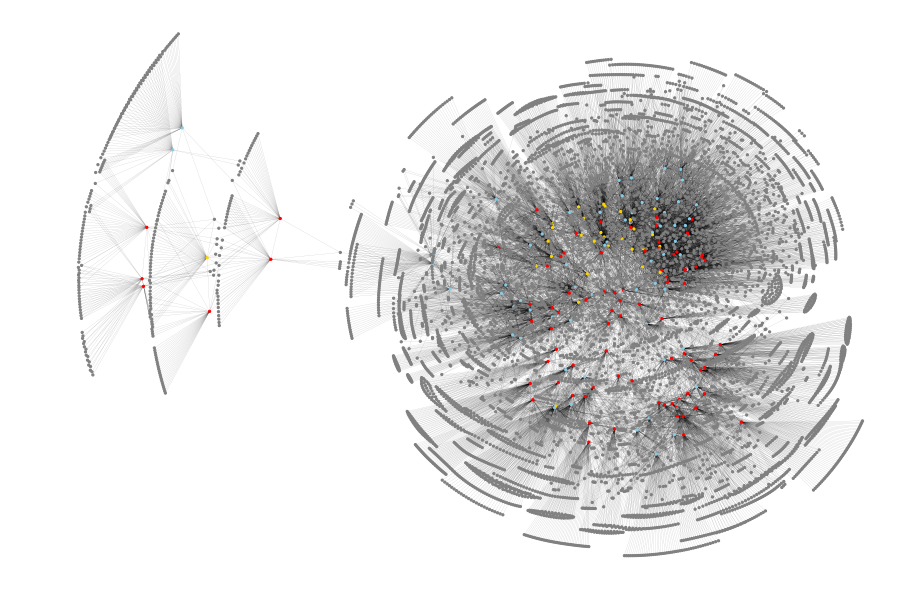

In [25]:
plt.figure(figsize=(12, 8))
nx.draw_kamada_kawai(g2, with_labels=False, node_size=5, node_color=node_colors2, width=0.05)
#nx.draw(g2, with_labels=False, node_size=5, width=0.2)
plt.show()

---
## Intersection Graph

In [46]:
table_sim = cases_similarity_top4[['source_case','similar_case','similarity_score','method','citation_link']].rename(
columns = {'source_case':'source','similar_case':'target',})

table_cit = citations_subset
table_cit['similarity_score'] = 0
table_cit['method'] = 'NoMethod'
table_cit['citation_link'] = True

inter_table = table_sim.append(table_cit)

In [47]:
inter_table.tail()

,source,target,similarity_score,method,citation_link
604,62017CO0232,62016CJ0519,0.0,NoMethod,True
605,62017CO0259,62016CJ0519,0.0,NoMethod,True
606,62016CJ0349,62016CO0508,0.0,NoMethod,True
607,62017CJ0111,62016CO0508,0.0,NoMethod,True
608,62017CJ0566,62017CJ0068,0.0,NoMethod,True


In [31]:
inter_table_pivot = pd.pivot_table(inter_table, 
                                   values='similarity_score', 
                                   index='target', 
                                   columns='source',
                                   aggfunc=np.mean)

In [32]:
inter_table_pivot.head()

source,61973CJ0039,61975CJ0004,61975CJ0043,61976CJ0089,61980CJ0132,61980CJ0272,61982CJ0174,61982CJ0314,61983CJ0001,61983CJ0037,...,62017CJ0573,62017CJ0581,62017CJ0619,62017CJ0620,62017CJ0634,62017CJ0713,62017CO0232,62017CO0259,62017CO0315,62018CO0780
target,,,,,,,,,,,,,,,,,,,,,
61954CJ0001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61954CJ0003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61954CJ0006,0.649365,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61954CJ0007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61954CJ0008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


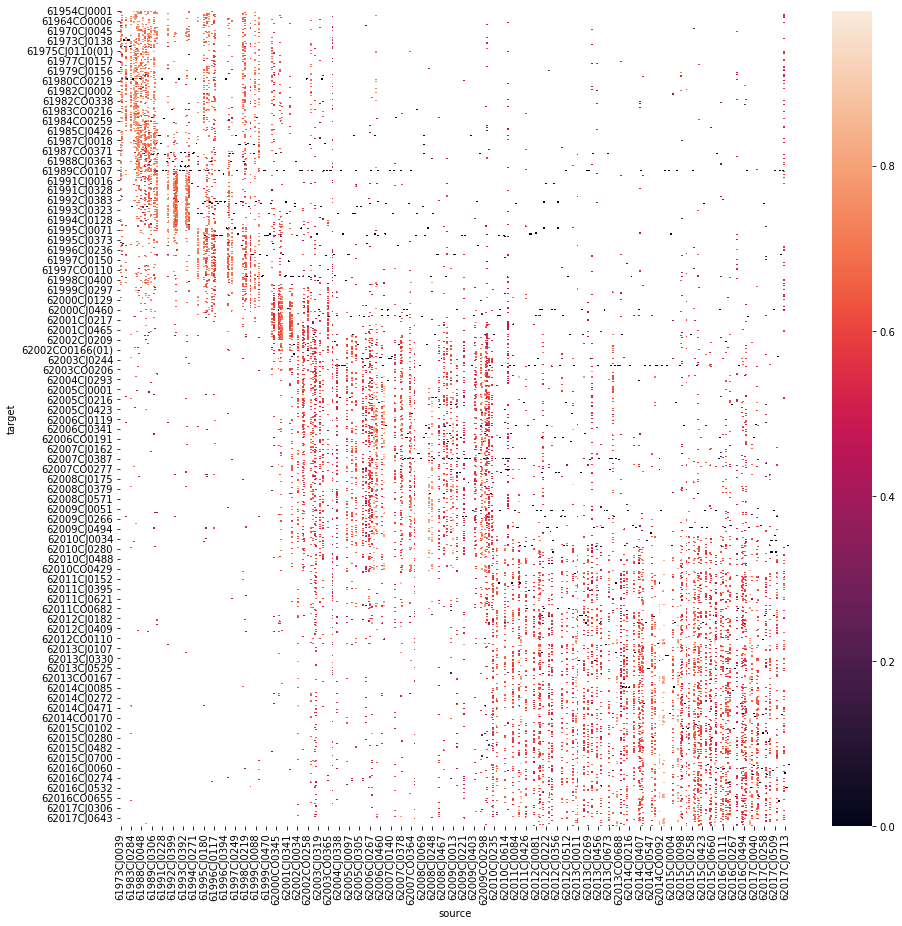

In [33]:
plt.figure(figsize=(15, 15))
sns.heatmap(inter_table_pivot)

In [66]:
summary_methods = inter_table\
    .groupby(['citation_link','method'])\
    .count()['target']\
    .reset_index()\
    .rename(columns={'target':'count'})\
    .sort_values('count', ascending=False)

In [67]:
summary_methods[summary_methods['citation_link']==True].head(10)

,citation_link,method,count
34,True,NoMethod,609
68,True,tfidf,190
42,True,doc2vec_256_10,22
41,True,doc2vec_256,20
36,True,doc2vec_128_10,19
35,True,doc2vec_128,18
52,True,doc2vec_256_e5,18
49,True,doc2vec_256_20_e10,17
51,True,doc2vec_256_e10,17
45,True,doc2vec_256_15,16


In [94]:
summary_methods[summary_methods['citation_link']==False].head(10)

,citation_link,method,count,method_ext
20,False,doc2vec_300_15_e5,1410,doc2vec
23,False,doc2vec_300_20_e5,1410,doc2vec
12,False,doc2vec_256_15_e5,1410,doc2vec
19,False,doc2vec_300_15_e10,1408,doc2vec
8,False,doc2vec_256_10_e10,1406,doc2vec
26,False,doc2vec_512_15_e5,1406,doc2vec
15,False,doc2vec_256_20_e5,1406,doc2vec
29,False,doc2vec_64_10_e10,1406,doc2vec_64
32,False,doc2vec_64_e5,1405,doc2vec_64
22,False,doc2vec_300_20_e10,1405,doc2vec


In [86]:
method_ext = []
for i in summary_methods["method"]:
    if i == 'tfidf':
        method_ext.append(i)
    elif i == 'NoMethod':
        method_ext.append(i)
    elif i.find("64") != -1:
        method_ext.append("doc2vec_64")
    else:
        method_ext.append("doc2vec")
summary_methods['method_ext'] = method_ext

In [92]:
summary_methods.groupby('method_ext').sum()

,citation_link,count
method_ext,,
NoMethod,1.0,609
doc2vec,27.0,38228
doc2vec_64,6.0,8496
tfidf,1.0,1416


---

In [34]:
cases_similarity_top4_link = cases_similarity_top4[
    cases_similarity_top4['citation_link'] == True].sort_values('source_case_topic')

In [35]:
len(cases_similarity_top4_link)

628

In [36]:
g3 = nx.from_pandas_edgelist(cases_similarity_top4_link, 'source_case', 'similar_case')
nx.set_node_attributes(g3, nodes)

In [37]:
#Graph description
N_nodes3, N_edges3 = g3.order(), g3.size()
avg_deg3 = float(N_nodes3)/N_edges3
print ('Nodes: {}\nEdges: {}\nAvg Degree: {}'.format(N_nodes3, N_edges3, avg_deg3) )

Nodes: 280
Edges: 219
Avg Degree: 1.278538812785388


In [38]:
node_colors3 = [find_color(node) for node in g3.nodes()]

/Users/pedrohserrano/anaconda3/envs/py37/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


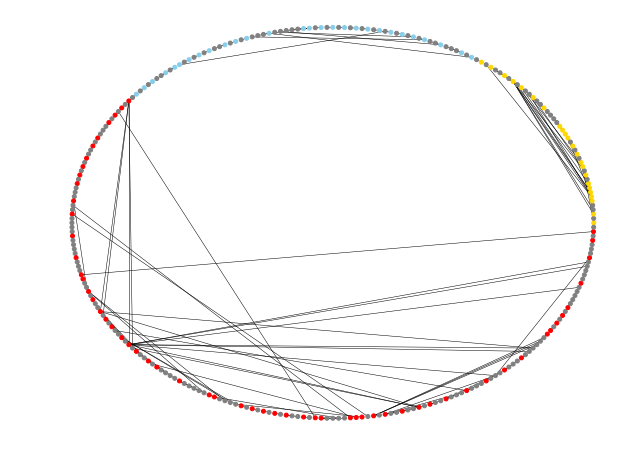

In [39]:
plt.figure(figsize=(8, 6))
nx.draw_circular(g3, with_labels=False, node_size=16, width=0.5, node_color=node_colors3)
plt.show()

---